In [1]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [13]:
from source.data_processing.cropping import crop_image
from source.visualization.image_visualization import (
    plot_image_with_crop,
    plot_images_with_matches_via_mapping,
)
import h5py
from source.data_processing.image_reading import read_image, downscale_image
from source.data_processing.cropping import create_crop_coordinate_mapping
import cv2
from torchvision.transforms import ToTensor
import torch
from source.loftr.backbone import ResNetFPN_16_4
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.data_processing.keypoints import translate_patch_midpoints_and_refine
from source.miscellaneous.evaluation import *
from source.loftr.fine_preprocess import FinePreprocess
import matplotlib.pyplot as plt
import numpy as np
from einops.einops import rearrange
from source.visualization.evaluation_visualization import plot_precision_vs_threshold
from source.visualization.evaluation_visualization import plot_precision_vs_threshold

Text(0.5, 1.0, 'Image 2')

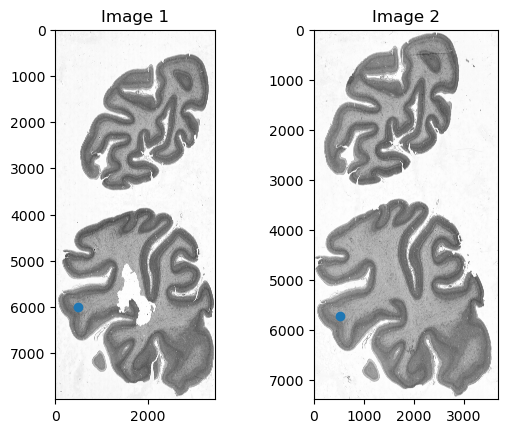

In [14]:
image_1 = read_image(
    r"C:\Users\robin\Desktop\temp\temp\B20_0524_Slice15.tif", size=(3463, 8000)
)
image_2 = read_image(
    r"C:\Users\robin\Desktop\temp\temp\B20_0525_Slice15.tif", size=(3668, 7382)
)
image_1, image_2 = ToTensor()(image_1), ToTensor()(image_2)

file_path = r"C:\Users\robin\Desktop\temp\temp\0524-0525_deformation_low_scale.h5"
f1 = h5py.File(file_path, "r")
deformation = cv2.resize(np.array(f1["deformation"]) // 10, (3463, 8000))
deformation = torch.Tensor(deformation).long()
deformation = torch.flip(deformation, dims=[-1])

index = [6000, 500]

import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Plot img1_ds_np in the first subplot
axs[0].imshow(image_1[0], cmap="gray")
axs[0].scatter(index[1], index[0])
axs[0].set_title("Image 1")


# Plot img2_ds_np in the second subplot
axs[1].imshow(image_2[0], cmap="gray")
axs[1].scatter(*deformation[index[0], index[1]])
axs[1].set_title("Image 2")

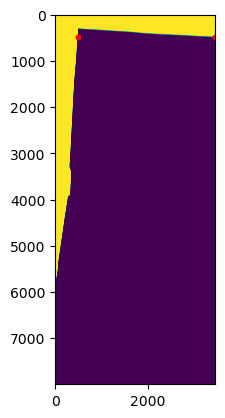

In [15]:
plt.imshow((deformation < 0).any(dim=2))
plt.scatter(496, 486, c="r", s=10)
plt.scatter(3462, 486, c="r", s=10)

## Load model

In [16]:
model_name = "lr0p0007_wd0p0015_coarse_contextFalse_img_size3344_3904_ResNet16_4_transform_threshold0p3_temp0p2_bs2_coarse_lossfocal_fine_lossl2_std_trainTrue_gamma1p5_alpha0p55_v3"

confidence_threshold = 0.9

block_dimensions = [64, 96, 128, 192]
fine_feature_size = block_dimensions[1]
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_16_4(block_dimensions=block_dimensions).cuda()
backbone.load_state_dict(torch.load(f"../../models/{model_name}/backbone.pt"))


positional_encoding = PositionalEncoding(coarse_feature_size).cuda()

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
).cuda()
coarse_loftr.load_state_dict(torch.load(f"../../models/{model_name}/coarse_loftr.pt"))

coarse_matcher = CoarseMatching(
    temperature=0.1, confidence_threshold=confidence_threshold
).cuda()

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=False,
).cuda()

fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
).cuda()
fine_loftr.load_state_dict(torch.load(f"../../models/{model_name}/fine_loftr.pt"))


fine_matching = FineMatching().cuda()

In [18]:
crop_size = 640
padding = 50

matches_image_1 = []
matches_image_2 = []
matches_image_2_not_refined = []

with torch.no_grad():
    for y in torch.arange(486 + padding, 8000 - crop_size - padding, crop_size):
        for x in torch.arange(496 + padding, 3463 - crop_size - padding, crop_size):
            crop_1 = crop_image(image_1, (x, y), crop_size)

            crop_2_position = deformation[y, x]
            crop_2 = crop_image(image_2, crop_2_position, crop_size)

            crop_coordinate_mapping = create_crop_coordinate_mapping(
                deformation,
                crop_position_image_1=(x, y),
                crop_position_image_2=crop_2_position,
                crop_size=crop_size,
            )
            crop_coordinate_mapping = crop_coordinate_mapping.cuda().unsqueeze(0)
            crop_1 = crop_1.cuda().unsqueeze(0)
            crop_2 = crop_2.cuda().unsqueeze(0)

            coarse_image_feature_1, fine_image_feature_1 = backbone(crop_1)
            coarse_image_feature_2, fine_image_feature_2 = backbone(crop_2)

            coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
            coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

            coarse_image_feature_1 = rearrange(
                coarse_image_feature_1, "n c h w -> n (h w) c"
            )
            coarse_image_feature_2 = rearrange(
                coarse_image_feature_2, "n c h w -> n (h w) c"
            )

            coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
                coarse_image_feature_1, coarse_image_feature_2
            )

            coarse_matches_predicted = coarse_matcher(
                coarse_image_feature_1, coarse_image_feature_2
            )
            match_matrix_predicted = coarse_matches_predicted["match_matrix"]

            fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
                coarse_image_feature_1=coarse_image_feature_1,
                coarse_image_feature_2=coarse_image_feature_2,
                fine_image_feature_1=fine_image_feature_1,
                fine_image_feature_2=fine_image_feature_2,
                coarse_matches=coarse_matches_predicted,
                fine_height=160,
                coarse_height=40,
            )

            fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
                fine_image_feature_1_unfold, fine_image_feature_2_unfold
            )

            predicted_relative_coordinates = fine_matching(
                fine_image_feature_1_unfold, fine_image_feature_2_unfold
            )

            match_matrix_predicted = match_matrix_predicted.cpu()
            predicted_relative_coordinates = predicted_relative_coordinates.cpu()

            (
                crop_1_patch_mid_coordinates,
                crop_2_patch_mid_coordinates,
                crop_2_patch_mid_coordinates_refined,
            ) = translate_patch_midpoints_and_refine(
                match_matrix=match_matrix_predicted,
                patch_size=16,
                relative_coordinates=predicted_relative_coordinates,
            )
            crop_1_patch_mid_coordinates += torch.Tensor([x, y]).long()
            crop_2_patch_mid_coordinates += crop_2_position
            crop_2_patch_mid_coordinates_refined += crop_2_position

            matches_image_1.append(crop_1_patch_mid_coordinates)
            matches_image_2.append(crop_2_patch_mid_coordinates_refined)
            matches_image_2_not_refined.append(crop_2_patch_mid_coordinates)

            # plot_images_with_matches_via_mapping(crop_1, crop_2, crop_coordinate_mapping, 20)
            # plot_image_with_crop(image_1, crop_1, (x, y))
            # plot_image_with_crop(image_2, crop_2, crop_2_position)

            ###########################
            # let loftr predict points between crops
            # add x and y to these so to translate them from crop to image scale
            # save points in global keypoint tensor idk
            ###########################

            # plot_image_with_crop(image_1, crop_1, (x, y))
            # plot_image_with_crop(image_2, crop_2, crop_2_position)

In [19]:
matches_image_1 = torch.concatenate(matches_image_1)
matches_image_2 = torch.concatenate(matches_image_2)
matches_image_2_not_refined = torch.concatenate(matches_image_2_not_refined)
matches_image_1.shape, matches_image_2.shape

(torch.Size([2549, 2]), torch.Size([2549, 2]))

The tensor __matches__ should be of shape (M, 4) where the 4 columns indicating the x,y coordinates of image 1 and 2

In [20]:
# create matches
matches = torch.column_stack((matches_image_1, matches_image_2))
matches_not_refined = torch.column_stack((matches_image_1, matches_image_2_not_refined))

tensor(7.3714)


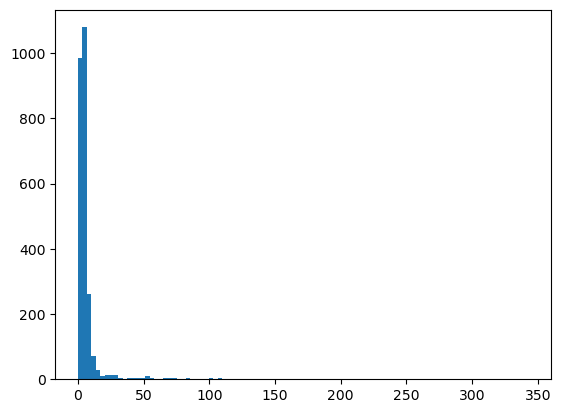

In [21]:
from source.miscellaneous.evaluation import compute_euclidean_distances

print(
    compute_euclidean_distances(
        predicted_matches=matches.float(), coordinate_mapping=deformation
    ).mean()
)
plt.hist(
    compute_euclidean_distances(
        predicted_matches=matches.float(), coordinate_mapping=deformation
    ),
    bins=100,
)
plt.show()

In [22]:
loftr_matches_image_1 = torch.load(
    r"C:\Users\robin\Desktop\temp\temp\0524-0525_deformation_low_scale_matches_image_1.pt"
)
loftr_matches_image_2 = torch.load(
    r"C:\Users\robin\Desktop\temp\temp\0524-0525_deformation_low_scale_matches_image_2.pt"
)
loftr_confidence = torch.load(
    r"C:\Users\robin\Desktop\temp\temp\0524-0525_deformation_low_scale_matches_confidence.pt"
)

confidence_threshold_loftr = 0.8
loftr_mask = loftr_confidence > confidence_threshold_loftr
loftr_matches_image_1 = loftr_matches_image_1[loftr_mask]
loftr_matches_image_2 = loftr_matches_image_2[loftr_mask]

loftr_matches = torch.column_stack((loftr_matches_image_1, loftr_matches_image_2))
loftr_matches.shape

torch.Size([2524, 4])

In [23]:
match_precision = {}
match_precision_not_refined = {}
match_precision_loftr = {}
for pixel_threshold in torch.arange(0, 10, 0.01):
    match_precision[pixel_threshold.item()] = (
        (
            compute_euclidean_distances(
                predicted_matches=matches.float(), coordinate_mapping=deformation
            )
            <= pixel_threshold
        )
        .float()
        .mean()
        .item()
    )
    match_precision_not_refined[pixel_threshold.item()] = (
        (
            compute_euclidean_distances(
                predicted_matches=matches_not_refined.float(),
                coordinate_mapping=deformation,
            )
            <= pixel_threshold
        )
        .float()
        .mean()
        .item()
    )
    match_precision_loftr[pixel_threshold.item()] = (
        (
            compute_euclidean_distances(
                predicted_matches=loftr_matches.float(), coordinate_mapping=deformation
            )
            <= pixel_threshold
        )
        .float()
        .mean()
        .item()
    )

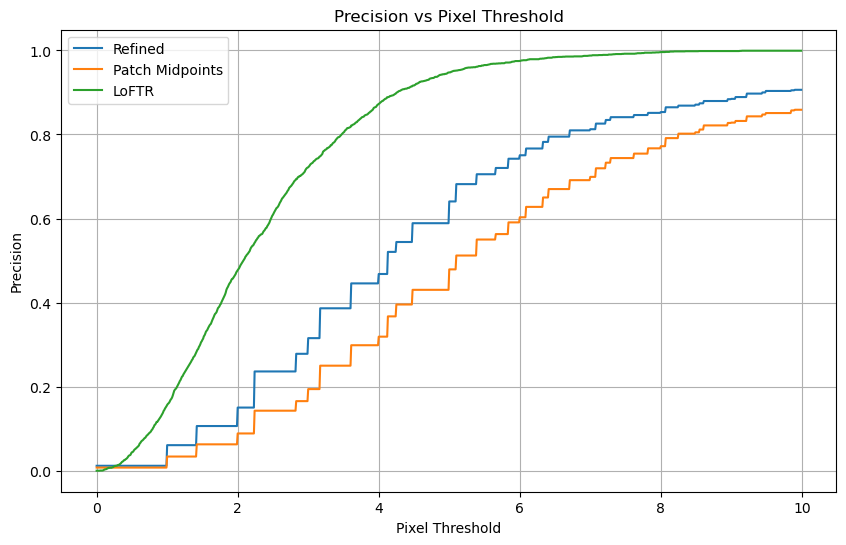

In [24]:
plot_precision_vs_threshold(
    match_precision,
    match_precision_not_refined,
    match_precision_loftr,
    labels=["Refined", "Patch Midpoints", "LoFTR"],
)

In [ ]:
y_borders = torch.arange(486, 8000, 64)
x_borders = torch.arange(496, 3463, 64)

In [ ]:
counts = count_matches_per_patch(loftr_matches, x_borders, y_borders)

c:\Users\robin\Documents\HyperBrain\source\miscellaneous\evaluation.py:65: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/BucketizationUtils.h:34.)
  x_indices = torch.searchsorted(x_borders, x_coords) - 1


In [ ]:
calculate_entropy(counts)

tensor(8.7435)

In [2]:
from source.miscellaneous.evaluation import evaluate_model

In [4]:
model_name = "1"

confidence_threshold = 0.95

block_dimensions = [64, 96, 128, 192]

evaluation_metrics = evaluate_model(
    [model_name], [confidence_threshold], [block_dimensions]
)

c:\Users\robin\Documents\HyperBrain\source\miscellaneous\evaluation.py:91: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/BucketizationUtils.h:34.)
  x_indices = torch.searchsorted(x_borders, x_coords) - 1
